# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [ ]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = (
    "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"
)

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")

## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [ ]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})
air = xr.open_dataset(TEMP_URL, chunks={"time": 8})
air

<xarray.Dataset> Size: 62MB
Dimensions:  (time: 1464, lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 12kB 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 62MB dask.array<chunksize=(8, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
precip = xr.open_dataset(PRECIP_URL, chunks={"time": 8})
precip

<xarray.Dataset> Size: 379MB
Dimensions:  (time: 366, lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    precip   (time, lat, lon) float32 379MB dask.array<chunksize=(8, 360, 720), meta=np.ndarray>
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.0
    version:                         V1.0
    title:                           CPC GLOBAL PRCP V1.0 RT
    dataset_title:                   CPC GLOBAL PRCP V1.0
    Source:                          ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_U...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    history:                         Updated 2021-01-02 23:31:03
    DODS_EXTRA.Unlimited_Dimension:  time

## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [ ]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.
air_us = air.sel(
    time=TIME_RANGE,
    lat=slice(LAT_RANGE[1], LAT_RANGE[0]),
    lon=slice(LON_RANGE_360[0], LON_RANGE_360[1]),
)
air_us

<xarray.Dataset> Size: 182kB
Dimensions:  (time: 120, lat: 13, lon: 29)
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Data variables:
    air      (time, lat, lon) float32 181kB dask.array<chunksize=(8, 13, 29), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
precip_us = precip.sel(
    time=TIME_RANGE,
    lat=slice(LAT_RANGE[1], LAT_RANGE[0]),
    lon=slice(LON_RANGE_360[0], LON_RANGE_360[1]),
)
precip_us

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 30, lat: 60, lon: 140)
Coordinates:
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Data variables:
    precip   (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.0
    version:                         V1.0
    title:                           CPC GLOBAL PRCP V1.0 RT
    dataset_title:                   CPC GLOBAL PRCP V1.0
    Source:                          ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_U...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    history:                         Updated 2021-01-02 23:31:03
    DODS_EXTRA.Unlimited_Dimension:  time

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [ ]:
# TODO: use xr.resample to create daily means.
air_daily = air_us.resample(time="D").mean()
air_daily

<xarray.Dataset> Size: 46kB
Dimensions:  (time: 30, lat: 13, lon: 29)
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Data variables:
    air      (time, lat, lon) float32 45kB dask.array<chunksize=(1, 13, 29), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [ ]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.
air_interp = air_daily.interp(lat=precip_us.lat, lon=precip_us.lon)
air_interp

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 30, lat: 60, lon: 140)
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Data variables:
    air      (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [ ]:
# TODO: build datasets and merge them into one object named `merged`.
merged = xr.merge(
    [
        air_interp.air.to_dataset(name="air_temperature"),
        precip_us.precip.to_dataset(name="daily_precip"),
    ]
)
merged

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>

## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [ ]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


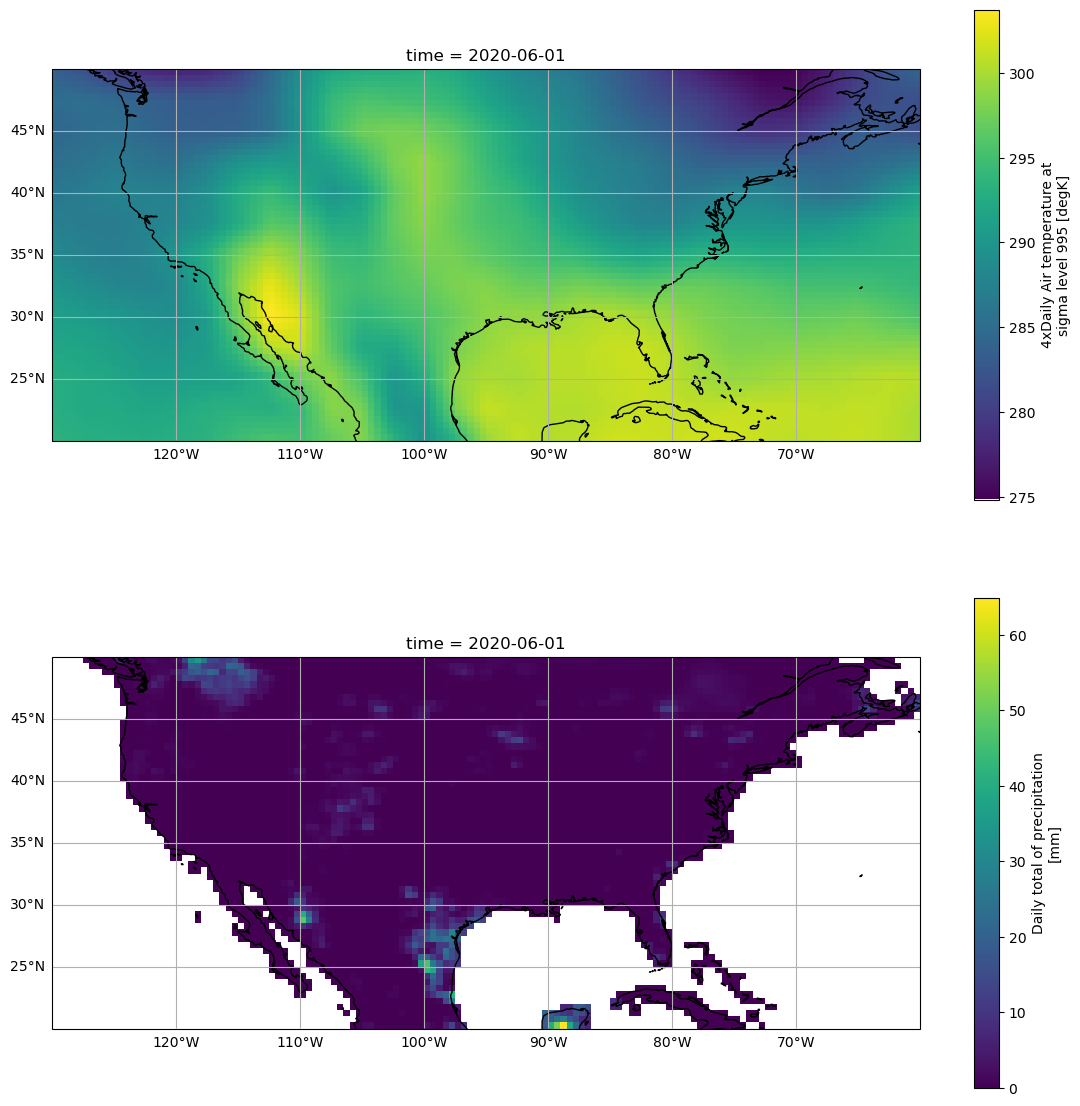

In [ ]:
fig, ax = plt.subplots(
    2, figsize=(14, 14), subplot_kw=dict(projection=ccrs.PlateCarree())
)

merged.air_temperature[0, :, :].plot(ax=ax[0])
merged.daily_precip[0, :, :].plot(ax=ax[1])
gl = ax[0].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax[0].coastlines()

gl = ax[1].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax[1].coastlines()

Text(0, 0.5, 'Precipitation (mm)')

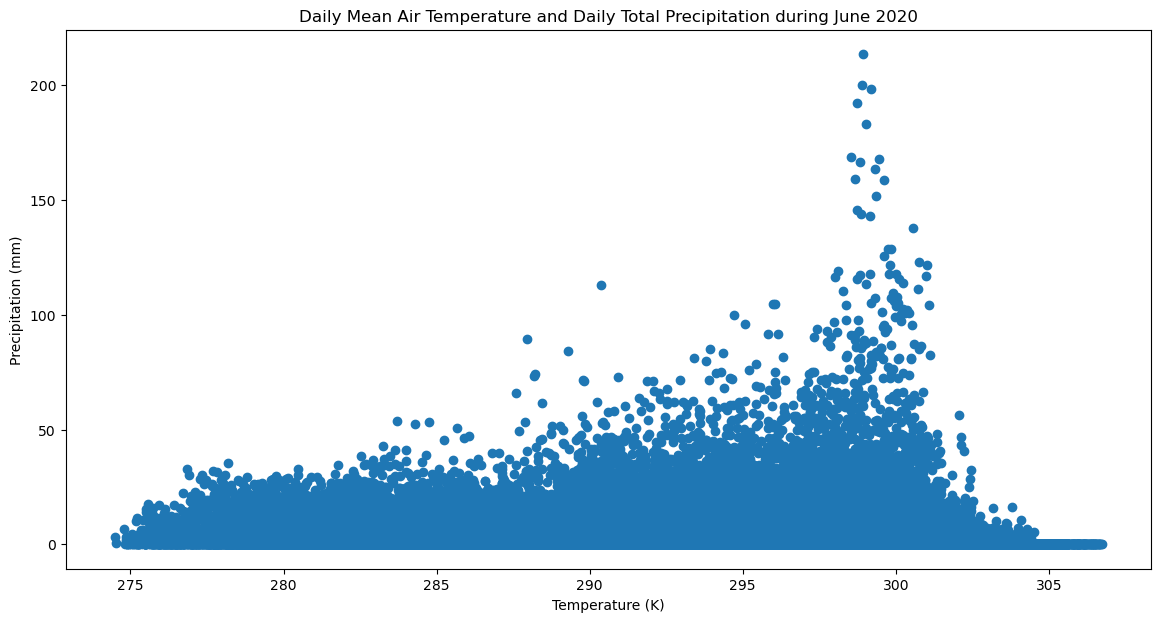

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(merged.air_temperature, merged.daily_precip)
ax.set_title(
    "Daily Mean Air Temperature and Daily Total Precipitation during June 2020"
)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Precipitation (mm)")

In [12]:
merged.to_netcdf("merged.nc")